In [1]:
import os
import bigframes.pandas as bf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time

In [2]:
bf.options.bigquery.project = 'credit-business-on-demand-9fd5'

In [3]:
query_tpv_master = f""" SELECT * FROM `dataplatform-prd.economic_research.sbca_monthly_metrics`"""
df_tpv_master = bf.read_gbq(query_tpv_master)
base_tpv_master = df_tpv_master.to_pandas()

In [4]:
query_estabelecimentos_municipios = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.estabelecimentos_municipio`"""
df_estabelecimentos_municipios = bf.read_gbq(query_estabelecimentos_municipios)
base_estabelecimentos_municipios = df_estabelecimentos_municipios.to_pandas()

In [5]:
query_enderecos_documentos = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.endereco_documentos`"""
df_enderecos_documentos = bf.read_gbq(query_enderecos_documentos)
base_enderecos_documentos = df_enderecos_documentos.to_pandas()

In [6]:
query_cnae_documentos = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.cnae_documentos`"""
df_cnae_documentos = bf.read_gbq(query_cnae_documentos)
base_cnae_documentos = df_cnae_documentos.to_pandas()

In [7]:
query_estabelecimentos_municipios_rf = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.estabelecimentos_municipio_rf`"""
df_estabelecimentos_municipios_rf = bf.read_gbq(query_estabelecimentos_municipios_rf)
base_estabelecimentos_municipios_rf = df_estabelecimentos_municipios_rf.to_pandas()

In [8]:
query_documentos_por_socio = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.documentos_por_socio`"""
df_documentos_por_socio = bf.read_gbq(query_documentos_por_socio)
base_documentos_por_socio = df_documentos_por_socio.to_pandas()

In [9]:
base_tpv_master['total_tpv_credit'] = base_tpv_master['share_tpv_credit']*base_tpv_master['tpv_total']

<Axes: xlabel='reference_month'>

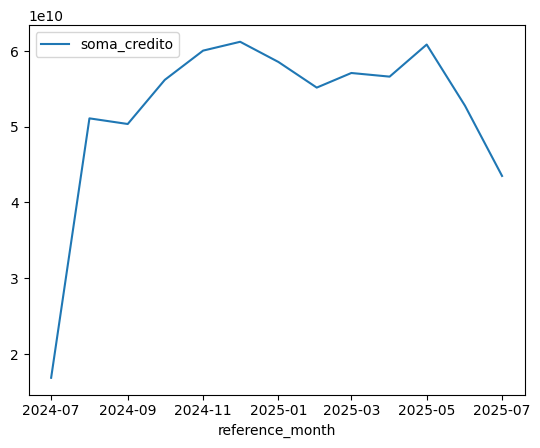

In [10]:
base_tpv_master.groupby(['reference_month']).agg(soma_credito=('total_tpv_credit','sum')).reset_index().sort_values(by=['reference_month']).plot(kind='line',x='reference_month')

In [11]:
base_tpv_master['month'] = base_tpv_master['reference_month'].dt.month
base_tpv_master['year'] = base_tpv_master['reference_month'].dt.year

In [12]:
# Juntando a base do TPV master com a localização dos documentos, para termos uma medida de faturamento total na cidade

In [13]:
base_tpv_master = base_tpv_master.merge(base_estabelecimentos_municipios_rf,how='left',left_on=['document'],right_on=['cpf_cnpj'])

In [14]:
base_tpv_master_agg = base_tpv_master.groupby(['month','year','municipio']).agg(total_tpv_credit_mun=('total_tpv_credit','sum')).reset_index()

In [15]:
base_tpv_master = base_tpv_master.merge(base_tpv_master_agg,how='left',on=['month','year','municipio'])

In [16]:
# Merge com a informação CNAE dos documentos

In [17]:
base_cnae_documentos['grupo_cnae_fiscal_principal'] = base_cnae_documentos['cnae_fiscal_principal'].astype(str).str[:2]

In [18]:
base_tpv_master = base_tpv_master.merge(base_cnae_documentos,how='left',left_on=['document'],right_on=['cpf_cnpj'])

In [19]:
# Merge com a informação de concorrência (mesmo CNAE/municipio)

In [20]:
base_estabelecimentos_municipios['month'] = base_estabelecimentos_municipios['ano_mes'].str[-2:].astype(int)
base_estabelecimentos_municipios['year'] = base_estabelecimentos_municipios['ano_mes'].str[:4].astype(int)

In [21]:
base_tpv_master = base_tpv_master.merge(base_estabelecimentos_municipios,how='left',left_on=['grupo_cnae_fiscal_principal','municipio','month','year'],right_on=['cnae_grupo','municipio','month','year'])

In [22]:
# Merge com a base de informação sobre os sócios 

In [23]:
base_tpv_master = base_tpv_master.merge(base_documentos_por_socio,how='left',left_on=['document'],right_on=['cpf_cnpj'])

In [24]:
base_tpv_master[['media_cnpjs_por_socio','qtd_socios_no_mes']] = base_tpv_master[['media_cnpjs_por_socio','qtd_socios_no_mes']].fillna(1)

In [25]:
base_tpv_master = base_tpv_master[['document', 'reference_month', 'tpv_stone', 'tpv_total',
       'share_tpv_debit', 'share_tpv_credit', 'share_tpv_chip_present',
       'share_tpv_chip_not_present', 'share_tpv_recurring', 'share_tpv_online',
       'average_ticket_size', 'average_spend_per_card',
       'average_transactions_per_card', 'origem_tpv', 'month', 'year',
       'total_tpv_credit', 'municipio', 'total_tpv_credit_mun',
       'grupo_cnae_fiscal_principal','total_estabelecimentos',
       'media_cnpjs_por_socio', 'qtd_socios_no_mes']]

In [26]:
# Filtro para considerar a partir de Agosto de 2024

In [27]:
base_tpv_master = base_tpv_master[(base_tpv_master['month'] >= 8)|(base_tpv_master['year'] >= 2025)]

In [28]:
base_tpv_master[['log_total_tpv_credit','log_total_tpv_credit_mun']] = np.log(base_tpv_master[['total_tpv_credit','total_tpv_credit_mun']])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: divide by zero encountered in log
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in log
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [29]:
base_tpv_master['log_total_tpv_credit_lag'] = (base_tpv_master.groupby('document')['log_total_tpv_credit'].shift(1))

In [30]:
base_tpv_master['municipio'] = base_tpv_master['municipio'].astype(str)

In [31]:
base_tpv_master = base_tpv_master[(~np.isinf(base_tpv_master['log_total_tpv_credit']))&(~np.isinf(base_tpv_master['log_total_tpv_credit_lag']))]

In [41]:
base_tpv_master.to_csv('base_tpv_master.csv',index=False)

In [32]:
base_rodagem = base_tpv_master[(base_tpv_master['month'] == 1)&(base_tpv_master['year'] == 2025)]

In [33]:
base_rodagem.shape

(1369586, 26)

array([[<Axes: title={'center': 'log_total_tpv_credit'}>,
        <Axes: title={'center': 'log_total_tpv_credit_lag'}>]],
      dtype=object)

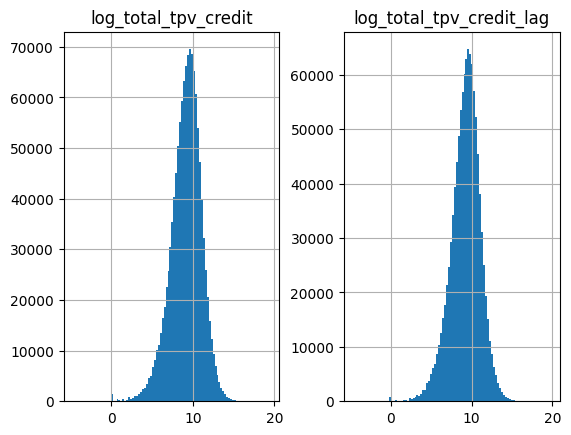

In [34]:
base_rodagem[['log_total_tpv_credit','log_total_tpv_credit_lag']].hist(bins=100)

In [35]:
begin = time.time()

In [36]:
model = smf.ols('log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes + C(municipio) + C(grupo_cnae_fiscal_principal)', data=base_rodagem).fit()

In [37]:
end = time.time()

In [38]:
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     log_total_tpv_credit   R-squared:                       0.737
Model:                              OLS   Adj. R-squared:                  0.735
Method:                   Least Squares   F-statistic:                     518.9
Date:                  Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                          13:21:12   Log-Likelihood:            -1.4315e+06
No. Observations:               1044274   AIC:                         2.874e+06
Df Residuals:                   1038674   BIC:                         2.941e+06
Df Model:                          5599                                         
Covariance Type:              nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [39]:
print(end - begin)

755.3973822593689


In [ ]:
# Analise dos residuos 

In [72]:
model_results = model.fittedvalues.reset_index()
model_results.rename(columns={0:'log_total_tpv_credit_pred'},inplace=True)

In [73]:
base_rodagem.reset_index(inplace=True)

In [74]:
base_resultados = base_rodagem.merge(model_results,on=['index'])

In [75]:
base_resultados['residuo'] = base_resultados['log_total_tpv_credit'] - base_resultados['log_total_tpv_credit_pred']

<Axes: >

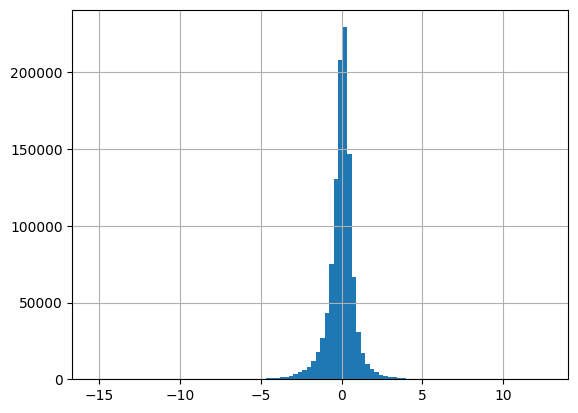

In [76]:
base_resultados['residuo'].hist(bins=100)

In [77]:
base_resultados['residuo_pct'] = np.exp(base_resultados['residuo']) - 1

In [78]:
base_resultados.to_csv('vencedores_03_25.csv',index=False)